<h1> Quantamental Trading Strategy

<h3> Abstract

<small> This notebook simulates a long-short quantitative equity trading strategy for U.S. stocks using fundamental ratios such as Price-to-Earnings (P/E), Return on Investment (ROI), and Debt-to-Market (D/M) from 2017 to 2024. The analysis begins with data cleaning and preparation using sources like ZACKS Fundamental Report B, QUOTE MEDIA Prices via Quandl, and FRED. Daily price data is merged with fundamental metrics to compute ratios, followed by implementing various long-short strategies by adjusting weights, retention thresholds, and other parameters. We will analyze equal weighted, value weighted, position sizing differences, and finally multiple ratios. The study concludes with an evaluation of risk factors, key insights, and potential limitations$^1$.

<h4> Guidelines$^1$

<small>
To construct our dataset, we randomly select at least **200 U.S. equity tickers** that satisfy the following conditions over the period January 2017 – June 2024:

1. **Price Data Availability**
   - End-of-day **adjusted closing prices** must be available for 2017-2024.
   - Filtered equities that show quarterly data

2. **Market Value Threshold**
   - The market capitalization (**MKTV**) must never fall below **$1 million**.

3. **Debt/Market Cap Ratio**
   - The **Debt/Market Cap ratio** must exceed **0.1** at some point during the period (preferably more than briefly).

4. **P/E Ratio**
   - If earnings are negative, we substitute them with **0.001**, though this results in an extremely high P/E.
   - Any stock with a **P/E ratio higher than 1,000** is removed from the dataset.

5. **Sector Exclusion**
   - The stock **must not belong** to the **automotive, financial, or insurance sectors**.

6. **Ratio Feasibility**
   - All required **fundamental ratios** must be calculable for the entire period.
   - At least one valid ratio calculation must exist per year.
   - A **debt ratio of zero is acceptable**.

7. **Trading Assumptions**
   - **Initial Capital:** $10M$ (In order to ensure capital > 0 for the purpose of the study)
   - **Trading Costs:** $0$
   - **Short Selling:**
     - All securities are **easy to borrow** at a **repo rate equal to 3M SOFR - 100 bps**.
     - To prevent excessively negative repo rates, they are **capped at -0.02%**.
    - **Rebalancing:** Positions are rebalanced every month

<h3> Data Cleaning

In [645]:


from pmh import *

warnings.filterwarnings("ignore", category=FutureWarning)
import importlib
import Quandl.Quandl_Python_Tables_API as quandl_api
import prep as prep
importlib.reload(prep)

<module 'prep' from '/Users/kunjshah/Downloads/QTS/Homework 3/prep.py'>

In [646]:
df = prep.load_data(quandl_api)
sample_df, sample_tickers = prep.valid_tickers_and_sample(df)   #download ZACKS Fundamental Data

Skipping any possible download of ZACKS/FC
Skipping any possible download of ZACKS/FR
Skipping any possible download of ZACKS/MT
Skipping any possible download of ZACKS/MKTV
Skipping any possible download of ZACKS/SHRS


In [647]:
price_sample = prep.stock_prices(sample_tickers, download=False)
price_full = prep.merge_samples(price_sample, sample_df)
stock_analysis_full = prep.calc_ratios_report(price_full)    #Merge with QUANDL MEDIA daily prices

In [648]:
stock_analysis = prep.filter_columns(stock_analysis_full) # Filter for only required columns

In [649]:

import analysis as analysis
importlib.reload(analysis)

<module 'analysis' from '/Users/kunjshah/Downloads/QTS/Homework 3/analysis.py'>

In [650]:
rates = analysis.fred()
stock_analysis = stock_analysis.merge(rates, on='date', how='inner')     #Merge repo rates

<H3> Hypothesis

This strategy is expected to exhibit high volatility and extreme returns over the 2017–2024 period. The primary driver of this volatility is the monthly rebalancing process, which introduces tracking error due to frequent position adjustments over a seven-year horizon. Additionally, since the strategy relies on daily fundamental ratios, it will be particularly sensitive to sharp fluctuations around filing dates, leading to significant shifts in portfolio composition and increased volatility.

<h4> Economic Context

<small>This strategy spans the period from 2017 to 2024, during which the market experienced multiple regime shifts driven by political and economic factors. Key market phases include a bull market (2017–2019), the COVID-19 crash (2020), the post-COVID rally (2021), and interest rate-driven corrections from 2022 onward. Given that the strategy does not hedge against the market factor, it will be exposed to broad market fluctuations, increasing its sensitivity to macroeconomic shocks and systemic risks.

<H3> Analysis

<h5> D/M Equal Weighted

In [651]:
performance_df_dm_ew, capital_dm_ew = analysis.execute_strategy(df = stock_analysis,
                 ratio_column = 'daily D/M',
                 initial_capital = 10_000_000,
                 n_positions = 10,
                 retention_threshold=0.2,
                 ascending = True,
                 equal_weight= True

                 )

In [652]:
display(performance_df_dm_ew)


,month,realized_pnl,costs,capital,return,num_positions,num_long,num_short,notional_traded,monthly_returns
0,2017-04,0.000000000000000,0.000000000000000,"10,000,000.000000000000000",0.000000000000000,20,10,10,"9,998,507.079550553113222",NaN
1,2017-05,"-176,958.049771349556977","-1,099.671741933631665","9,832,221.403551682829857",-0.016777859644832,21,10,11,"9,831,520.636051047593355",-0.016777859644832
2,2017-06,"251,010.641039102367358","-1,123.546180051407418","10,001,412.541841628029943",0.000141254184163,22,11,11,"10,000,239.513774875551462",0.017207824289720
3,2017-07,"-25,794.815513538458617",206.394482255434781,"10,066,758.264163156971335",0.006675826416316,23,12,11,"10,065,300.608113816007972",0.006533649326848
4,2017-08,"-170,164.159851227595937","1,118.008839042679483","10,101,011.212410928681493",0.010101121241093,22,11,11,"10,098,069.908641155809164",0.003402579792713
...,...,...,...,...,...,...,...,...,...,...
82,2024-02,"965,501.760079862899147","263,164.852788310789037","23,140,197.980224411934614",1.314019798022441,21,11,10,"23,139,086.751024089753628",0.015352870298075
83,2024-03,"227,649.938907111209119","255,957.130540034326259","23,308,741.770974390208721",1.330874177097439,21,11,10,"23,307,738.178016770631075",0.007283593290516
84,2024-04,"-121,109.354932315080077","256,603.478529239684576","23,395,416.609525274485350",1.339541660952527,21,11,10,"23,394,457.934369560331106",0.003718555012644
85,2024-05,"1,508,194.216230539837852","258,777.807454590714769","24,785,566.092473652213812",1.478556609247365,22,11,11,"24,784,453.497956398874521",0.059419736188087


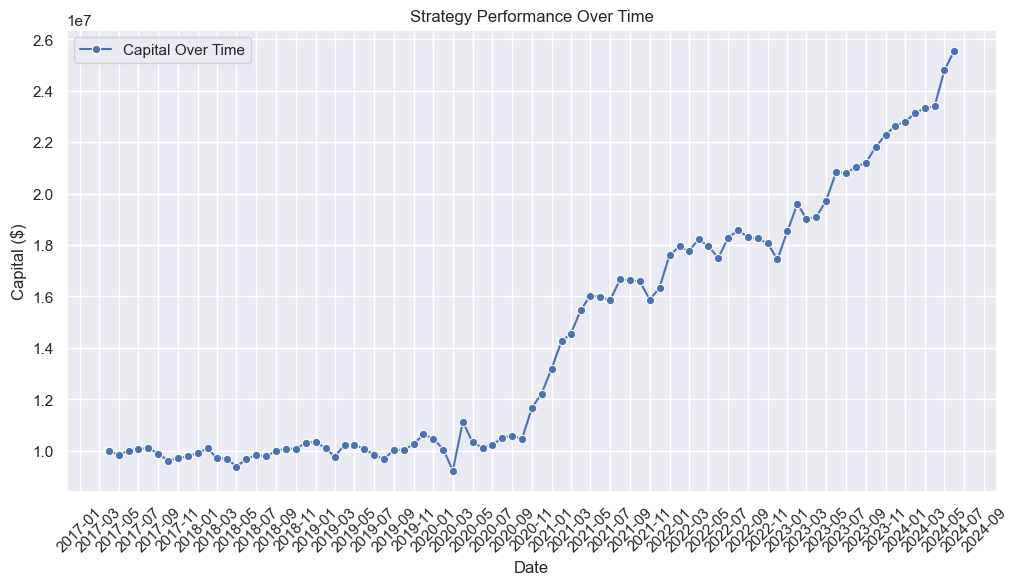

In [653]:
analysis.plot_strategy_performance(performance_df_dm_ew)

In [654]:
dm_ew_stats = analysis.calculate_risk_metrics(performance_df_dm_ew)
display(dm_ew_stats)
print(f"Equal Weighted Ending Capital: ${capital_dm_ew:,.2f}")

,Value
Metric,
Sharpe Ratio,4.712481125797422
Downside Beta,1.000000000000000
Max Drawdown,-0.132014536957231
VaR 5%,-0.037598153257805
CVaR 5%,-0.055178442183433
P&L to Notional,0.010153860232733


Equal Weighted Ending Capital: $25,954,937.53


<h5> ROI Equal Weighted

In [655]:
performance_df_roi_ew, capital_roi = analysis.execute_strategy(df = stock_analysis,
                 ratio_column = 'daily_roi',
                 initial_capital = 10_000_000,
                 n_positions = 10,
                 retention_threshold=0.2,
                 ascending = True,
                 equal_weight= True

                 )

In [656]:
display(performance_df_roi_ew)

,month,realized_pnl,costs,capital,return,num_positions,num_long,num_short,notional_traded,monthly_returns
0,2017-04,0.000000000000000,0.000000000000000,"10,000,000.000000000000000",0.000000000000000,20,10,10,"9,998,403.301101330667734",NaN
1,2017-05,"-77,627.384845866006799","-1,199.813710532449250","10,010,805.077458636835217",0.001080507745864,20,10,10,"10,009,448.858904343098402",0.001080507745864
2,2017-06,"-183,882.935533936280990","-1,097.016836883356746","9,953,241.788846351206303",-0.004675821115365,20,10,10,"9,952,337.549031596630812",-0.005750115816549
3,2017-07,"-102,038.830310850695241",245.408822689788707,"9,969,054.214130425825715",-0.003094578586957,20,10,10,"9,968,110.600738743320107",0.001588670869203
4,2017-08,"181,999.161722076620208",819.259083721348929,"10,174,441.071904994547367",0.017444107190499,21,11,10,"10,173,753.490076554939151",0.020602441652233
...,...,...,...,...,...,...,...,...,...,...
82,2024-02,"717,267.269322411040775","122,479.328991030066391","16,807,442.941798530519009",0.680744294179853,22,12,10,"16,806,359.596052169799805",0.031257484215696
83,2024-03,"115,596.592770814022515","166,341.967525403277250","16,669,726.883720031008124",0.666972688372003,22,11,11,"16,669,068.755732942372561",-0.008193754312026
84,2024-04,"457,752.562918988871388","193,433.050414094264852","16,801,203.556370314210653",0.680120355637031,22,11,11,"16,800,134.242729108780622",0.007887152175162
85,2024-05,"758,114.445570771349594","127,033.807150309788994","17,079,678.744711972773075",0.707967874471197,21,10,11,"17,078,381.479999613016844",0.016574716650943


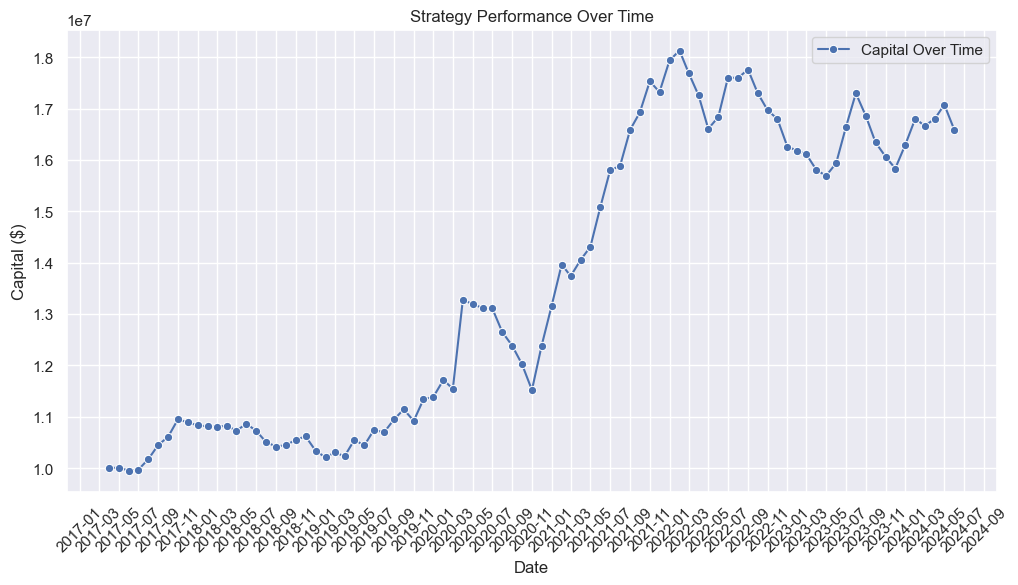

In [657]:
analysis.plot_strategy_performance(performance_df_roi_ew)

In [658]:
dm_roi_stats = analysis.calculate_risk_metrics(performance_df_roi_ew)
display(dm_roi_stats)
print(f"Equal Weighted Ending Capital: ${capital_roi:,.2f}")

,Value
Metric,
Sharpe Ratio,3.377386295241378
Downside Beta,1.000000000000000
Max Drawdown,-0.134442898038463
VaR 5%,-0.030129213264754
CVaR 5%,-0.035547316534205
P&L to Notional,0.005461446312170


Equal Weighted Ending Capital: $19,093,247.86


<h5> P/E
- For this strategy we will look at both equal and value weighted portfolios

In [659]:
importlib.reload(analysis)

<module 'analysis' from '/Users/kunjshah/Downloads/QTS/Homework 3/analysis.py'>

In [660]:
performance_df_pe_ew, capital_pe_ew = analysis.execute_strategy(df = stock_analysis,
                 ratio_column = 'daily P/E',
                 initial_capital = 10_000_000,
                 n_positions = 10,
                 retention_threshold=0.2,
                 ascending = True,
                 equal_weight= True
                 )

performance_df_pe_vw, capital_pe_vw = analysis.execute_strategy(df = stock_analysis,
                 ratio_column = 'daily P/E',
                 initial_capital = 10_000_000,
                 n_positions = 10,
                 retention_threshold=0.2,
                 ascending = True,
                 equal_weight= False
                 )

In [661]:
display(performance_df_pe_ew)
display(performance_df_pe_vw)

,month,realized_pnl,costs,capital,return,num_positions,num_long,num_short,notional_traded,monthly_returns
0,2017-04,0.000000000000000,0.000000000000000,"10,000,000.000000000000000",0.000000000000000,20,10,10,"9,998,538.531826961785555",NaN
1,2017-05,"219,223.471461822482524","-1,099.892058241188352","10,174,327.566681839525700",0.017432756668184,20,10,10,"10,173,703.227100206539035",0.017432756668184
2,2017-06,"230,751.177918593661161","-1,059.218717060670770","10,273,269.599051173776388",0.027326959905117,21,10,11,"10,272,640.852317493408918",0.009724675338088
3,2017-07,"266,707.987001342815347",183.475437681250895,"10,278,475.298757659271359",0.027847529875766,21,10,11,"10,277,990.106149638071656",0.000506722777621
4,2017-08,"185,160.695979616575642",858.842892438094964,"10,389,261.443157369270921",0.038926144315737,21,10,11,"10,388,998.877922156825662",0.010778460927284
...,...,...,...,...,...,...,...,...,...,...
82,2024-02,"17,324.023699621597189","25,844.776871975718677","2,935,379.735521810129285",-0.706462026447819,21,11,10,"2,934,242.508795278612524",-0.014521313134956
83,2024-03,"-119,806.813277496446972","32,454.495758555956854","2,863,039.541779552586377",-0.713696045822045,21,11,10,"2,862,082.330472452566028",-0.024644236950623
84,2024-04,"35,235.114000044457498","29,856.662451480828167","2,861,752.162993531674147",-0.713824783700647,20,10,10,"2,860,840.876326289493591",-0.000449654560209
85,2024-05,"-8,422.453745751005044","23,317.016908934092498","2,839,714.079787648748606",-0.716028592021235,23,12,11,"2,837,576.717650633770972",-0.007700905581855


,month,realized_pnl,costs,capital,return,num_positions,num_long,num_short,notional_traded,monthly_returns
0,2017-04,0.000000000000000,0.000000000000000,"10,000,000.000000000000000",0.000000000000000,20,10,10,"9,999,266.494103781878948",NaN
1,2017-05,"172,273.536519916699035","-1,018.080108306694569","10,164,929.785686230286956",0.016492978568623,20,10,10,"10,164,279.859166128560901",0.016492978568623
2,2017-06,"444,399.756294333259575","-1,012.634593397785011","10,356,822.374370643869042",0.035682237437064,21,10,11,"10,355,903.947185961529613",0.018877905969860
3,2017-07,"397,426.288568965683226",123.133242530205280,"10,386,072.853990461677313",0.038607285399046,21,10,11,"10,385,512.929280063137412",0.002824271631056
4,2017-08,"132,308.326501808391185",866.460880809537571,"10,469,716.475706510245800",0.046971647570651,21,10,11,"10,469,399.474339818581939",0.008053440688500
...,...,...,...,...,...,...,...,...,...,...
82,2024-02,"74,137.077007781015709","26,193.291593749123422","2,697,255.132645209785551",-0.730274486735479,21,11,10,"2,694,796.786084865219891",-0.016414047731790
83,2024-03,"-44,511.229652893875027","29,942.851385706442670","2,660,566.663756006397307",-0.733943333624399,21,11,10,"2,658,077.204770870506763",-0.013602149995067
84,2024-04,"48,645.650781128060771","27,427.974472224908823","2,672,194.026839131955057",-0.732780597316087,20,10,10,"2,670,959.805668510030955",0.004370258126406
85,2024-05,"-31,210.451100504433271","21,201.621860935014411","2,641,447.184117406141013",-0.735855281588259,23,12,11,"2,639,681.240443519316614",-0.011506216394809


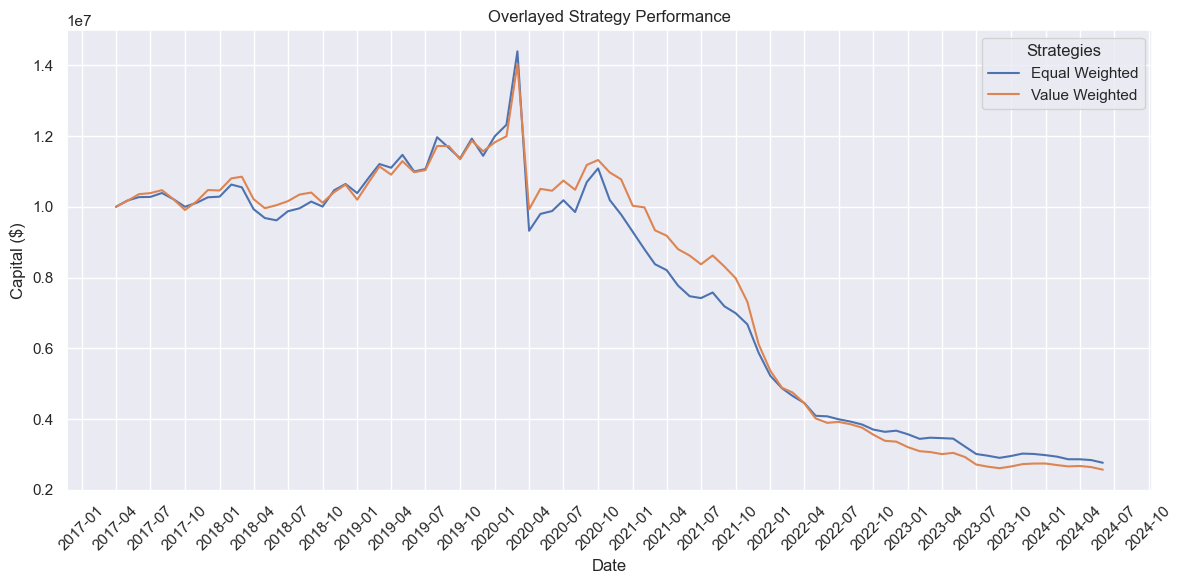

In [662]:
strategy_data_list = [performance_df_pe_ew, performance_df_pe_vw]
strategy_name_list = ['Equal Weighted', 'Value Weighted']
analysis.plot_overlayed_strategies(strategy_data_list, strategy_name_list)

In [663]:
ew_stats = analysis.calculate_risk_metrics(performance_df_pe_ew)
vw_stats = analysis.calculate_risk_metrics(performance_df_pe_vw)
display(ew_stats)
display(vw_stats)
print(f"Equal Weighted Ending Capital: ${capital_pe_ew:,.2f}")
print(f"Value Weighted Ending Capital: ${capital_pe_vw:,.2f}")

,Value
Metric,
Sharpe Ratio,-3.692509708779473
Downside Beta,1.000000000000000
Max Drawdown,-0.808025857443206
VaR 5%,-0.077392022980169
CVaR 5%,-0.149177229283957
P&L to Notional,-0.017174672162307


,Value
Metric,
Sharpe Ratio,-4.186185833807535
Downside Beta,1.000000000000000
Max Drawdown,-0.816975521507057
VaR 5%,-0.088110310403844
CVaR 5%,-0.153129745903877
P&L to Notional,-0.017676666363938


Equal Weighted Ending Capital: $2,984,919.19
Value Weighted Ending Capital: $2,616,618.36


<small>The equal weighted strategy holding 10 positions with a retention threshold of 20% has relatively terrible returns across 7 years. The downside beta of 1 shows that there is no protection against the market during declines, which is this context makes sense as we don't hedge out the market. At the same time a lot of the stocks may have high correlations to the market. The CVAR shows that during market declines, this strategy on average loses more than 5% at -14.9%. The value weighted shows a lower sharpe, and a lower CVAR. This could be due to the fact that we are allocating more funds relative to the top and bottom ranks. This exaggerates the volatility. Both portfolios lost nearly 75% ending at around 2.5M-3M.

<h4> Ratio Comparision

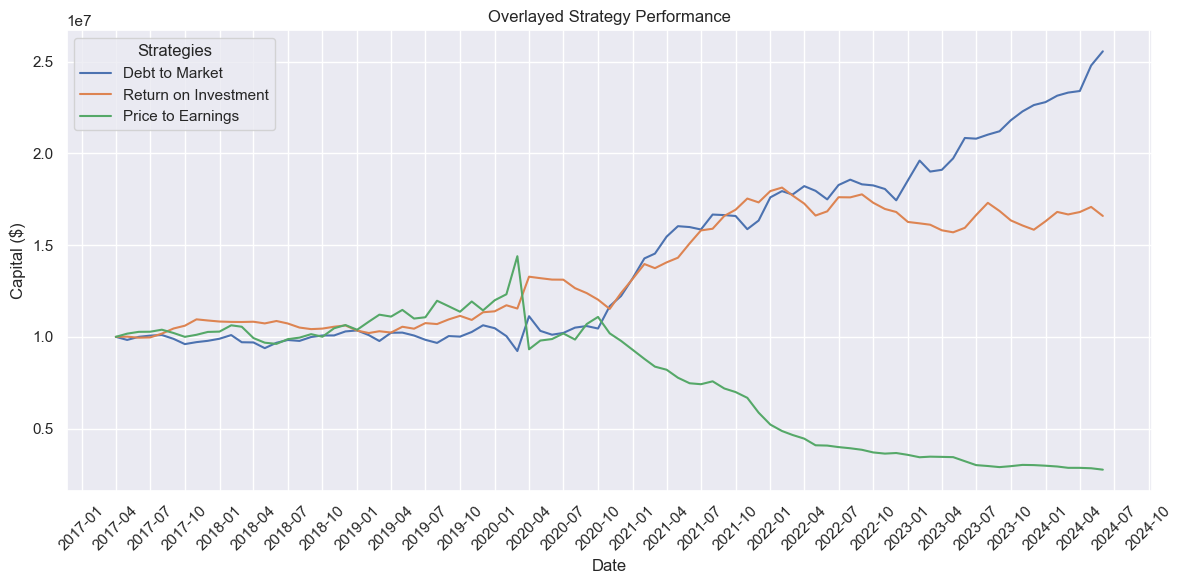

In [664]:
strategy_df_list = [performance_df_dm_ew, performance_df_roi_ew, performance_df_pe_ew]
strategy_name_list = ['Debt to Market', 'Return on Investment', 'Price to Earnings']

analysis.plot_overlayed_strategies(strategy_df_list, strategy_name_list)

<small>Examining closely on 2020 around covid crash we see a sharp drop in the P/E ratio strategy contrasted by an uptick in D/M and ROI strategy. This can be due to several economic factors in calculating the daily ratios. The economy for a few weeks was on pause, and prices decreased dramatically, regardless of the equal weight across top and bottom ranks for P/E, we still see a cumulative decline. From there P/E ratio strategy never recovered.The equal weighted portfolios for debt to market and return on investment are both positive strategies for this sample, with a share greater than 4, and 3 respectively across the time horizon. All three strategy returns are not as volatile as I expected as across 7 years the pct change was less than 12% per year both positive and negative

<h4> Multiple Ratio Analysis: P/E & D/M

Explain why

In [665]:
multi_strat_dm_pe, capital_multi_dm_pe = analysis.execute_strategy_multiple_ratio(stock_analysis,
                                                       ratio_columns = ['daily D/M', 'daily P/E'],
                                                       initial_capital = 10_000_000,
                                                       n_positions = 10,
                                                       retention_threshold=0.2,
                                                       ascending = True,
                                                       equal_weight= True)


In [666]:
display(multi_strat_dm_pe)

,month,realized_pnl,costs,capital,return,num_positions,num_long,num_short,notional_traded,monthly_returns
0,2017-04,0.000000000000000,0.000000000000000,"10,000,000.000000000000000",0.000000000000000,20,10,10,"9,999,295.606035128235817",NaN
1,2017-05,"30,108.068276664555015","-1,199.911820319249045","10,042,136.420674310997128",0.004213642067431,22,10,12,"10,041,659.525337835773826",0.004213642067431
2,2017-06,"257,721.945363415405154","-1,345.398737352836633","10,191,637.379659289494157",0.019163737965929,21,10,11,"10,190,936.056076962500811",0.014887365867406
3,2017-07,"233,006.698465830471832",23.379100214430139,"10,227,172.681371910497546",0.022717268137191,22,11,11,"10,226,595.246523553505540",0.003486711741093
4,2017-08,"-140,996.544583629118279","1,064.626436377898699","10,097,342.248990910127759",0.009734224899091,22,10,12,"10,096,878.474864684045315",-0.012694655348636
...,...,...,...,...,...,...,...,...,...,...
89,2024-09,"894,567.648899760446511","203,396.636019747180399","19,000,286.446761474013329",0.900028644676147,20,10,10,"18,999,620.660437203943729",0.018525384435032
90,2024-10,"-97,629.173306290642358","155,744.230319746420719","18,863,521.065867517143488",0.886352106586752,23,12,11,"18,861,770.030072625726461",-0.007198069422646
91,2024-11,"47,286.739902461267775","169,411.250670980633004","19,225,478.975086055696011",0.922547897508606,21,11,10,"19,224,595.803860083222389",0.019188247409095
92,2024-12,"295,318.113860084675252","169,620.096126262127655","19,440,941.205174945294857",0.944094120517495,21,10,11,"19,440,038.780000001192093",0.011207118967912


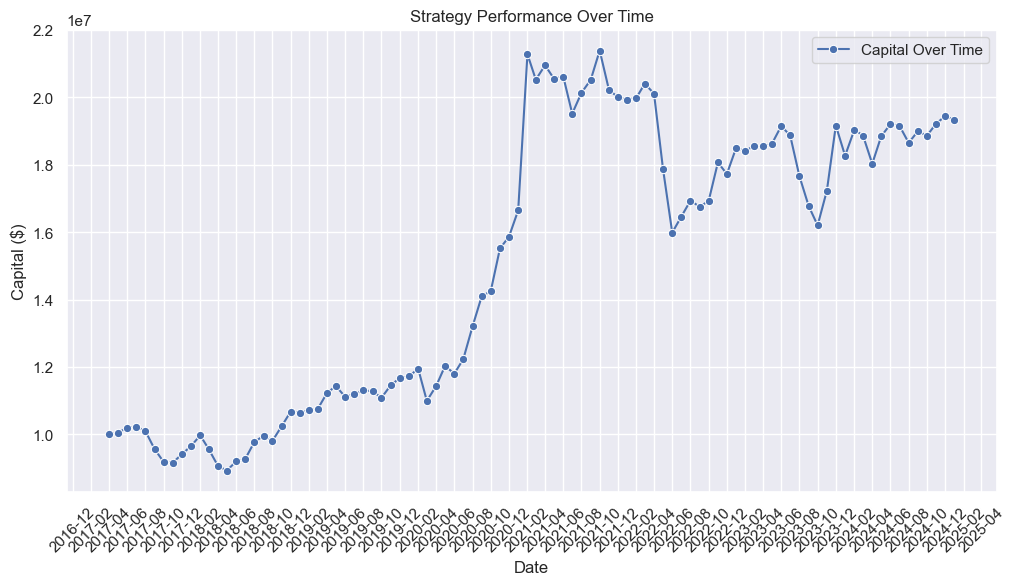

In [667]:
analysis.plot_strategy_performance(multi_strat_dm_pe)

In [668]:
multi_metrics = analysis.calculate_risk_metrics(multi_strat_dm_pe)
display(multi_metrics)
print(f"Capital at the End: ${capital_multi_dm_pe:,.2f}")

,Value
Metric,
Sharpe Ratio,2.717785367433748
Downside Beta,1.000000000000000
Max Drawdown,-0.252653877621577
VaR 5%,-0.053800479638655
CVaR 5%,-0.083060115999730
P&L to Notional,0.006041783472028


Capital at the End: $19,345,563.07


Plotting all Multi-Ratio strategies

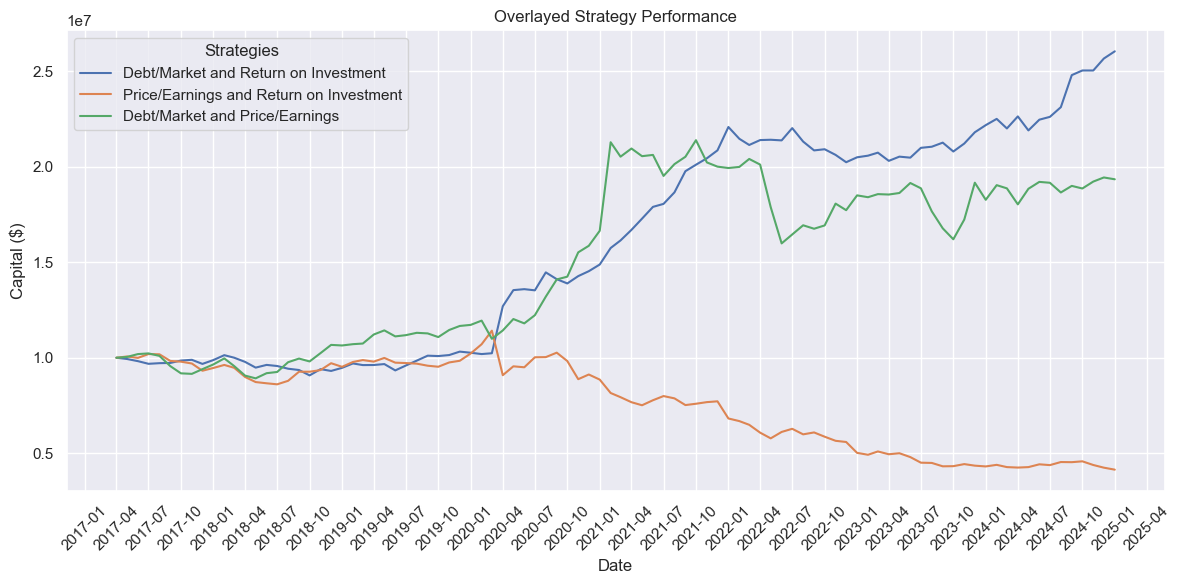

End capital for D/M & ROI: 26,046,704.18
End capital for D/M & P/E: 19,345,563.07
End capital for P/E & ROI: 4,139,075.43


In [669]:
multi_strat_dm_roi, capital_dm_roi = analysis.execute_strategy_multiple_ratio(stock_analysis,
                                                       ratio_columns = ['daily D/M', 'daily_roi'],
                                                       initial_capital = 10_000_000,
                                                       n_positions = 10,
                                                       retention_threshold=0.2,
                                                       ascending = True,
                                                       equal_weight= True)
multi_strat_roi_pe, capital_roi_pe = analysis.execute_strategy_multiple_ratio(stock_analysis,
                                                       ratio_columns = ['daily P/E', 'daily_roi'],
                                                       initial_capital = 10_000_000,
                                                       n_positions = 10,
                                                       retention_threshold=0.2,
                                                       ascending = True,
                                                       equal_weight= True)

multi_strat_list = [multi_strat_dm_roi, multi_strat_roi_pe, multi_strat_dm_pe]
multi_strat_name = ['Debt/Market and Return on Investment', 'Price/Earnings and Return on Investment', 'Debt/Market and Price/Earnings']
analysis.plot_overlayed_strategies(multi_strat_list, multi_strat_name)

print(f"End capital for D/M & ROI: {capital_dm_roi:,.2f}")
print(f"End capital for D/M & P/E: {capital_multi_dm_pe:,.2f}")
print(f"End capital for P/E & ROI: {capital_roi_pe:,.2f}")

<small>
This strategy employs a relative ranking based on both P/E and D/M. Prior analysis has shown that D/M and ROI generate positive returns, prompting a comparison against P/E and D/M to assess their effectiveness. The results indicate that this strategy produces a lower Sharpe ratio than the D/M-only strategy and approximately $6 million less in returns. However, compared to the P/E-only strategy, it yields significantly higher returns. Additionally, the CVaR (5%) is reduced by half, though downside beta remains unchanged across all portfolios, likely due to its correlation with the broader market.

<h4> Return on ratio

In [670]:
performance_df_pe_change, capital_pe_change = analysis.execute_strategy_ratio_change(
    df = stock_analysis,
    ratio_column = 'daily P/E',
    initial_capital = 10_000_000,
    n_positions = 10,
    retention_threshold=0.2,
    ascending = True,
    equal_weight= True
)

performance_df_dm_change, capital_dm_change = analysis.execute_strategy_ratio_change(
    df = stock_analysis,
    ratio_column = 'daily D/M',
    initial_capital = 10_000_000,
    n_positions = 10,
    retention_threshold=0.2,
    ascending = True,
    equal_weight= True
)

performance_df_roi_change, capital_roi_change = analysis.execute_strategy_ratio_change(
    df = stock_analysis,
    ratio_column = 'daily_roi',
    initial_capital = 10_000_000,
    n_positions = 10,
    retention_threshold=0.2,
    ascending = True,
    equal_weight= True
)

In [671]:
performance_df_pe_change_metrics = analysis.calculate_risk_metrics(performance_df_pe_change)
performance_df_dm_change_metrics = analysis.calculate_risk_metrics(performance_df_dm_change)
performance_df_roi_change_metrics = analysis.calculate_risk_metrics(performance_df_roi_change)

display(performance_df_pe_change_metrics)
display(performance_df_dm_change_metrics)
display(performance_df_roi_change_metrics)

,Value
Metric,
Sharpe Ratio,-2.121556212221861
Downside Beta,1.000000000000000
Max Drawdown,-0.573747611677687
VaR 5%,-0.060888800989339
CVaR 5%,-0.153914781295308
P&L to Notional,-0.010925424153396


,Value
Metric,
Sharpe Ratio,0.144225811872279
Downside Beta,1.000000000000000
Max Drawdown,-0.282597900148472
VaR 5%,-0.064411539576379
CVaR 5%,-0.088576928385336
P&L to Notional,-0.002591159337608


,Value
Metric,
Sharpe Ratio,0.316826525395400
Downside Beta,1.000000000000000
Max Drawdown,-0.214682306472787
VaR 5%,-0.055650405416017
CVaR 5%,-0.072992896956833
P&L to Notional,-0.000425093097094


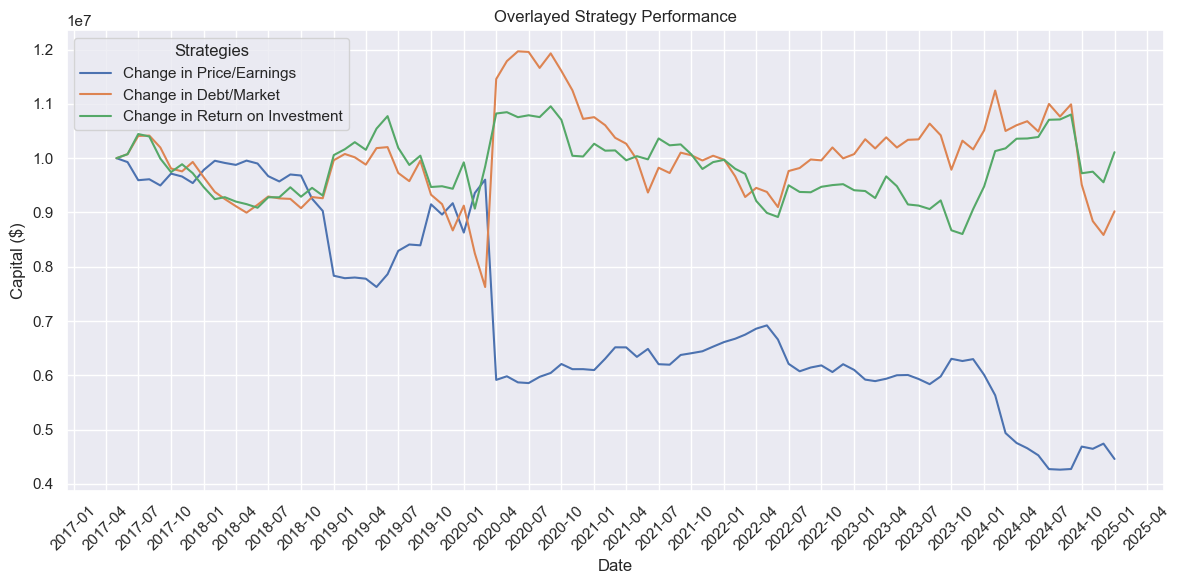

End capital for P/E: 4,459,538.24
End capital for D/M: 9,021,357.89
End capital for ROI: 10,109,943.54


In [672]:
change_ratio_list = [performance_df_pe_change, performance_df_dm_change, performance_df_roi_change]
change_ratio_name = ['Change in Price/Earnings', 'Change in Debt/Market', 'Change in Return on Investment']
analysis.plot_overlayed_strategies(change_ratio_list, change_ratio_name)

print(f"End capital for P/E: {capital_pe_change:,.2f}")
print(f"End capital for D/M: {capital_dm_change:,.2f}")
print(f"End capital for ROI: {capital_roi_change:,.2f}")

Analyzing the change in ratio and ranking based relative MoM change shows us a differnt picture for the strategies. We see the D/M and ROI strategy stays relatively constant throughout 7 years actually showing very little to no volatility. Even for the P/E we see a decreased volatility than compared to ranking the rtios themselves.

<h3> Flexible positions

In [673]:
performance_df_flx_pe, capital_flx_pe = analysis.execute_strategy_flex(
    df = stock_analysis,
    ratio_column = 'daily P/E',
    initial_capital = 10_000_000,
    long_short_ratio= .1,
    retention_threshold=0.2,
    ascending = True,
    equal_weight= True
)

performance_df_flx_dm, capital_flx_dm = analysis.execute_strategy_flex(
    df = stock_analysis,
    ratio_column = 'daily D/M',
    initial_capital = 10_000_000,
    long_short_ratio= .1,
    retention_threshold=0.2,
    ascending = True,
    equal_weight= True
)

performance_df_flx_roi, capital_flx_roi = analysis.execute_strategy_flex(
    df = stock_analysis,
    ratio_column = 'daily_roi',
    initial_capital = 10_000_000,
    long_short_ratio= .1,
    retention_threshold=0.2,
    ascending = True,
    equal_weight= True
)

In [674]:
performance_df_flx_pe_metrics = analysis.calculate_risk_metrics(performance_df_flx_pe)
performance_df_flx_dm_metrics = analysis.calculate_risk_metrics(performance_df_flx_dm)
performance_df_flx_roi_metrics = analysis.calculate_risk_metrics(performance_df_flx_roi)

display(performance_df_flx_pe_metrics)
display(performance_df_flx_dm_metrics)
display(performance_df_flx_roi_metrics)

,Value
Metric,
Sharpe Ratio,-4.292240146622028
Downside Beta,1.000000000000000
Max Drawdown,-0.719575806689330
VaR 5%,-0.055727991278417
CVaR 5%,-0.104323472967336
P&L to Notional,-0.012202719353049


,Value
Metric,
Sharpe Ratio,4.749320391768542
Downside Beta,1.000000000000000
Max Drawdown,-0.106331526762840
VaR 5%,-0.019276090773189
CVaR 5%,-0.035403295084515
P&L to Notional,0.008041242346466


,Value
Metric,
Sharpe Ratio,2.047624694497483
Downside Beta,1.000000000000000
Max Drawdown,-0.154630472382469
VaR 5%,-0.027424216670848
CVaR 5%,-0.044157526859096
P&L to Notional,0.002555461699284


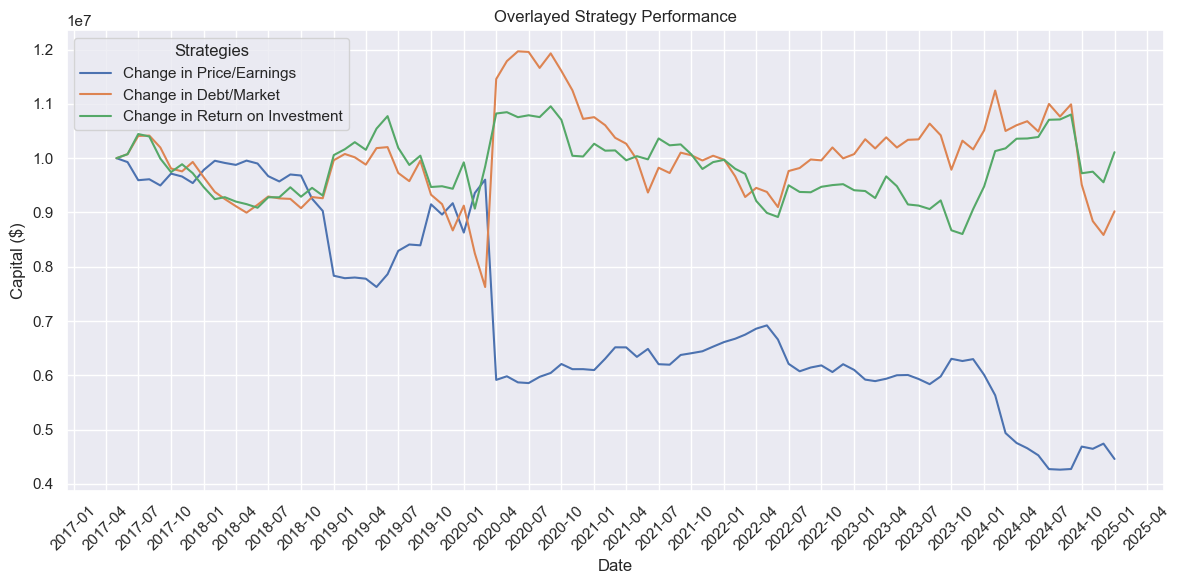

End capital for P/E: 3,521,746.19
End capital for D/M: 21,975,105.50
End capital for ROI: 13,019,368.53


In [675]:
performance_flx_list = [performance_df_pe_change, performance_df_dm_change, performance_df_roi_change]
performance_flx_name = ['Price/Earnings', 'Debt/Market', 'Return on Investment']
analysis.plot_overlayed_strategies(change_ratio_list, change_ratio_name)

print(f"End capital for P/E: {capital_flx_pe:,.2f}")
print(f"End capital for D/M: {capital_flx_dm:,.2f}")
print(f"End capital for ROI: {capital_flx_roi:,.2f}")

This strategy keeps equal weighted values, but changes the positon size for the strategy. Instead of constantly using ten positons, we utilize a percentage point, effectively increasing our diversity accross the strategy, but decreassing the amount allocated to each positon. We see similar returns in this regard, as the ranking of each strategy is constant, with debt to market being on top.

<h4>Comprehensive Analysis

In [676]:
from pmh import *
import pmh as calc_stats

In [677]:
multi_strat_all, capital_all = analysis.execute_strategy_multiple_ratio(df = stock_analysis,
                                                                        ratio_columns = ['daily D/M',
                                                                                         "daily P/E",
                                                                                         "daily_roi"],
                                                                        initial_capital = 10_000_000,
                                                                        n_positions= 10,
                                                                        retention_threshold = 0.2,
                                                                        ascending = True,
                                                                        equal_weight= True
                                                                        )
performance_df_dm_vw, capital_dm_vw = analysis.execute_strategy_flex(df = stock_analysis,
                                                                     ratio_column = 'daily D/M',
                                                                     initial_capital = 10_000_000,
                                                                     long_short_ratio= .1,
                                                                     retention_threshold= .2,
                                                                     ascending = True,
                                                                    equal_weight= False)

performance_df_roi_vw, capital_roi_vw = analysis.execute_strategy_flex(df = stock_analysis,
                                                                       ratio_column = 'daily_roi',
                                                                       initial_capital = 10_000_000,
                                                                       long_short_ratio= .1,
                                                                       retention_threshold= .2,
                                                                       ascending = True,
                                                                       equal_weight= False)

In [678]:
# Dictionary mapping DataFrame names to actual DataFrames
dfs = {
    "performance_df_dm_ew": performance_df_dm_ew,
    "performance_df_roi_ew": performance_df_roi_ew,
    "performance_df_pe_ew": performance_df_pe_ew,
    "performance_df_pe_vw": performance_df_pe_vw,
    "performance_df_dm_vw": performance_df_dm_vw,
    "performance_df_roi_vw": performance_df_roi_vw,
    "multi_strat_dm_pe": multi_strat_dm_pe,
    "multi_strat_dm_roi": multi_strat_dm_roi,
    "multi_strat_roi_pe": multi_strat_roi_pe,
    "multi_strat_all": multi_strat_all,
    "performance_df_pe_change": performance_df_pe_change,
    "performance_df_dm_change": performance_df_dm_change,
    "performance_df_roi_change": performance_df_roi_change,
    "performance_df_flx_dm": performance_df_flx_dm,
    "performance_df_flx_roi": performance_df_flx_roi,
    "performance_df_flx_pe": performance_df_flx_pe,
}

# Dictionary mapping DataFrame names to descriptions
mapping = {
    "performance_df_dm_ew": "Equal Weighted D/M",
    "performance_df_roi_ew": "Equal Weighted ROI",
    "performance_df_pe_ew": "Equal Weighted P/E",
    "performance_df_pe_vw": "Value Weighted P/E",
    "performance_df_dm_vw": "Value Weighted D/M",
    "performance_df_roi_vw": "Value Weighted ROI",
    "multi_strat_dm_pe": "D/M & P/E",
    "multi_strat_dm_roi": "D/M & ROI",
    "multi_strat_roi_pe": "P/E & ROI",
    "multi_strat_all": "D/M, P/E, ROI",
    "performance_df_pe_change": "Change in Price/Earnings",
    "performance_df_dm_change": "Change in Debt/Market",
    "performance_df_roi_change": "Change in ROI",
    "performance_df_flx_dm": "Flexible Positions D/M",
    "performance_df_flx_roi": "Flexible Positions ROI",
    "performance_df_flx_pe": "Flexible Positions P/E",
}

# Compute risk metrics for all DataFrames
metrics_result = analysis.calculate_risk_metrics_for_all(dfs, mapping)

# Display the final metrics DataFrame
metrics_result.T

,Sharpe Ratio,Downside Beta,Max Drawdown,VaR 5%,CVaR 5%,P&L to Notional
Equal Weighted D/M,4.712481125797422,1.000000000000000,-0.132014536957231,-0.037598153257805,-0.055178442183433,0.010153860232733
Equal Weighted ROI,3.377386295241378,1.000000000000000,-0.134442898038463,-0.030129213264754,-0.035547316534205,0.005461446312170
Equal Weighted P/E,-3.692509708779473,1.000000000000000,-0.808025857443206,-0.077392022980169,-0.149177229283957,-0.017174672162307
Value Weighted P/E,-4.186185833807535,1.000000000000000,-0.816975521507057,-0.088110310403844,-0.153129745903877,-0.017676666363938
Value Weighted D/M,5.913174803689710,1.000000000000000,-0.088004610956385,-0.021548629776838,-0.033063712647542,0.010012709801226
Value Weighted ROI,0.927332021241417,1.000000000000000,-0.187974657717159,-0.040728330323268,-0.055287498104908,0.000873299184326
D/M & P/E,2.717785367433748,1.000000000000000,-0.252653877621577,-0.053800479638655,-0.083060115999730,0.006041783472028
D/M & ROI,5.118950064675206,1.000000000000000,-0.104544942469091,-0.028806804273606,-0.031910450491109,0.009764562386155
P/E & ROI,-3.383805519352769,1.000000000000000,-0.637502177448563,-0.069722214394770,-0.119700803318644,-0.010441522860564
"D/M, P/E, ROI",2.312740251343527,1.000000000000000,-0.257805293438043,-0.041771742716272,-0.048779891833740,0.003269988237099


The highest correlation (94.80%) is between Equal Weighted P/E and Value Weighted P/E
The lowest correlation (-84.80%) is between Change in Debt/Market and Change in Price/Earnings


<Axes: >

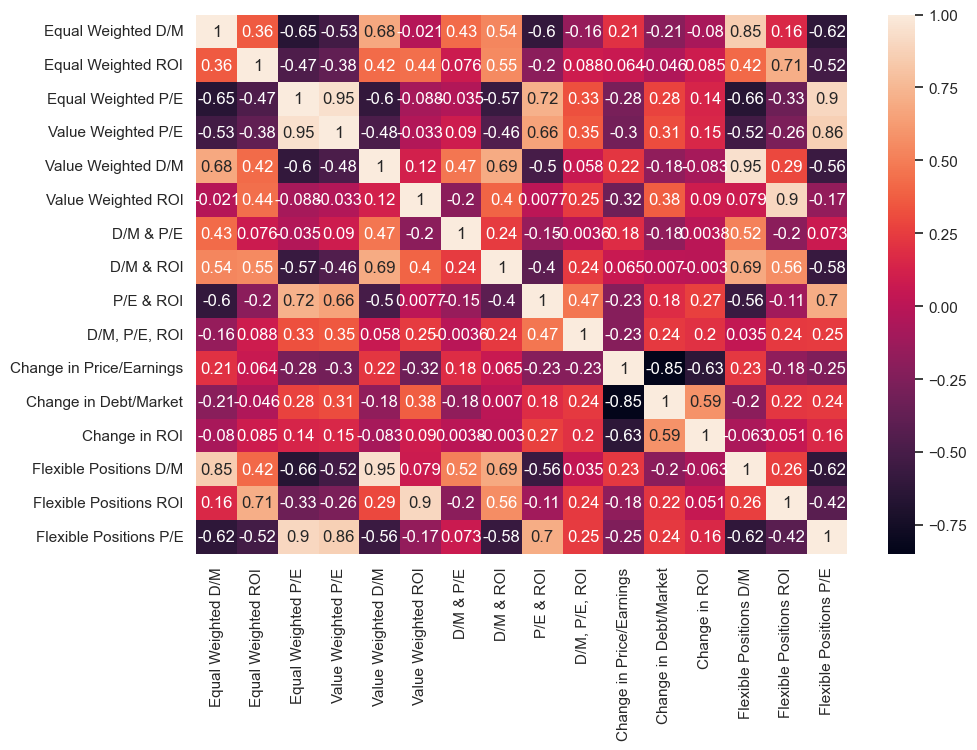

In [679]:
renamed_dfs = analysis.rename_columns(dfs, mapping)
returns_df = pd.DataFrame()

for df_name, df in renamed_dfs.items():
        returns_col = analysis.find_column_by_keyword(df, "returns")
        returns_series = df[[returns_col]].rename(columns={returns_col: mapping[df_name]})
        returns_df = pd.concat([returns_df, returns_series], axis=1)

returns_df = pd.DataFrame(returns_df)
calc_stats.calc_correlations(returns_df)

In [680]:
mean_returns = returns_df.mean()
volatility_returns = returns_df.std()
annualized_mean= returns_df.mean() * 12
annualized_volatility = returns_df.std() * np.sqrt(12)

returns_stats_df = pd.DataFrame({
    'Mean Return': mean_returns,
    'Volatility': volatility_returns,
    'Annualized Mean' : annualized_mean,
    'Annualized Volatility' : annualized_volatility
})
returns_stats_df = pd.DataFrame(returns_stats_df)
returns_stats_df

,Mean Return,Volatility,Annualized Mean,Annualized Volatility
Equal Weighted D/M,0.011705832566658,0.039432376746247,0.140469990799890,0.136597759975394
Equal Weighted ROI,0.006324358853776,0.029725970202338,0.075892306245317,0.102973781389457
Equal Weighted P/E,-0.013072103363528,0.056198418972646,-0.156865240362332,0.194677033931330
Value Weighted P/E,-0.014135429907516,0.053603208784817,-0.169625158890188,0.185686962128050
Value Weighted D/M,0.010897064373349,0.029254256783906,0.130764772480187,0.101339718174782
Value Weighted ROI,0.001646934890604,0.028193009922519,0.019763218687254,0.097663451208193
D/M & P/E,0.008200304067001,0.047897745340097,0.098403648804017,0.165922656994086
D/M & ROI,0.010865470332443,0.033695189850481,0.130385643989311,0.116723561583423
P/E & ROI,-0.008591764771257,0.040306701040417,-0.103101177255080,0.139626508174984
"D/M, P/E, ROI",0.004036092853245,0.027703494895758,0.048433114238941,0.095967721413355


<small> Across all strategies, we observe a downside beta of 1, indicating that the portfolios move in line with the market during downturns, offering no significant downside protection.

Notably, the P/E strategy experienced the highest maximum drawdown, suggesting it was the weakest performer in this context. High P/E stocks are typically associated with growth companies but can also indicate overvaluation over certain periods. This could help explain the portfolio’s overall return profile.

Interestingly, the strategy went long on high Debt/Market (D/M) stocks, which may initially seem counterintuitive. However, in this case, it proved effective. Companies with high D/M ratios often have stable cash flows, making them more resilient in low interest rate environments, where borrowing costs are favorable. This dynamic likely contributed to the strategy’s success

We see a variety of correlation across the portfolios. Naturally the portfolios that utilize the same strategy, have higher correlations, but we see just how negatively correlated D/M and ROI is to P/E$^1$.

<h3> Conclusion

Throughout this notebook, we conducted a quantamental analysis of various strategies. My initial hypothesis was ultimately proven false, as the observed volatility levels were relatively low. Even in the highest-volatility strategy, the annualized volatility reached only 22%, suggesting that these strategies exhibited more stability than initially expected. Some potential drawbacks are the sample size of the stocks used in the strategy as well as the time period. TThese can severly differeienate returns. $^1$.

<h5> Footnotes

<small> $^1$: AI was utilized to rewrite based on grammer and tone